### 라이브러리 정의

In [1]:
# 데이터 처리 라이브러리
import pandas as pd
import numpy as np
# 분석알고리즘 DecisionTree 구현 라이브러리
from sklearn.tree import DecisionTreeRegressor 
# 과거데이터를 8:2, 7:3 이나 이런식으로 자동으로 나누어주는 라이브러리
from sklearn.model_selection import train_test_split

In [70]:
# 분석 알고리즘 DecisionTree 구현 라이브러리
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [71]:
# 딥러닝에서 많이씀!
from sklearn.preprocessing import LabelEncoder

# 정확도를 위한 지표들(분석(Regression)의 대표 평가지표 MAE, RMSE)
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

### 데이터 불러오기

In [85]:
featuresData = \
    pd.read_csv("../dataset/feature_regression_example.csv")
featuresData.head(2)

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT
0,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201501,2015,1,1225,Y,1,Y,0.209442
1,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201502,2015,2,968,N,4,Y,0.209442
2,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201503,2015,3,1209,N,4,Y,0.208155
3,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201504,2015,4,1810,Y,2,Y,0.208155
4,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201505,2015,5,1773,N,4,Y,0.208155
...,...,...,...,...,...,...,...,...,...,...,...,...
100,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201648,2016,48,2412,Y,0,Y,0.421888
101,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201649,2016,49,1955,N,4,Y,0.421888
102,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201650,2016,50,1800,N,4,Y,0.352361
103,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201651,2016,51,1173,N,4,Y,0.352361


### 1. 데이터 전처리

### 1-1. 타입 통합 / 특성 숫자컬럼 추가

### 1-1-1. 데이터 타입 통합

In [84]:
featuresData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   REGIONID       105 non-null    object 
 1   PRODUCTGROUP   105 non-null    object 
 2   PRODUCT        105 non-null    object 
 3   ITEM           105 non-null    object 
 4   YEARWEEK       105 non-null    int64  
 5   YEAR           105 non-null    int64  
 6   WEEK           105 non-null    int64  
 7   QTY            105 non-null    float64
 8   HOLIDAY        105 non-null    object 
 9   HCLUS          105 non-null    int64  
 10  PROMOTION      105 non-null    object 
 11  PRO_PERCENT    105 non-null    float64
 12  HOLIDAY_NEW    105 non-null    int32  
 13  PROMOTION_NEW  105 non-null    int32  
dtypes: float64(2), int32(2), int64(4), object(6)
memory usage: 10.8+ KB


In [6]:
# 주의할 사항은 모든 컬럼에 대해서 고정시키는걸 고려햐는게 나을수도 있다
featuresData.QTY = featuresData.QTY.astype(float)

### 1-1-2. 특성 값 숫자컬럼 변경

In [72]:
## 이유 : 머신러닝 특성은 숫자형을 지원함 ( 해결 Y : 1로 , N : 0으로 변환)
### 특성도 있고 답도 있다! -> 스스로 학습함

In [73]:
##  어떤 컬럼들이 있는지 확인
featuresData.columns

Index(['REGIONID', 'PRODUCTGROUP', 'PRODUCT', 'ITEM', 'YEARWEEK', 'YEAR',
       'WEEK', 'QTY', 'HOLIDAY', 'HCLUS', 'PROMOTION', 'PRO_PERCENT',
       'HOLIDAY_NEW', 'PROMOTION_NEW'],
      dtype='object')

In [75]:
# np.where을 쓰든 loc function을 쓰든
featuresData["HOLIDAY_NEW"] = \
    np.where(featuresData.HOLIDAY=="Y",1,0)

In [76]:
# np.where을 쓰든 loc function을 쓰든
featuresData["PROMOTION_NEW"] = \
    np.where(featuresData.PROMOTION=="Y",1,0)

In [87]:
# pd.DataFrame(featuresData.HOLIDAY.drop_duplicates() ).reset_index().\
#     rename(columns={"index":"HOLIDAY_NEW"})

### 1-2. 특성 선정 / 데이터 분리

### 1-2-1. 특성 선정

In [9]:
# 상관계수
featuresData.corr()

,YEARWEEK,YEAR,WEEK,QTY,HCLUS,PRO_PERCENT,HOLIDAY_NEW,PROMOTION_NEW
YEARWEEK,1.000000,0.956598,0.275593,0.112267,-0.071586,0.404889,0.049867,0.205916
YEAR,0.956598,1.000000,-0.016493,0.028931,0.028593,0.321193,-0.031106,0.195931
WEEK,0.275593,-0.016493,1.000000,0.289766,-0.339943,0.329705,0.273710,0.060206
QTY,0.112267,0.028931,0.289766,1.000000,-0.537230,0.700195,0.505932,0.612451
HCLUS,-0.071586,0.028593,-0.339943,-0.537230,1.000000,-0.545619,-0.974601,-0.374072
PRO_PERCENT,0.404889,0.321193,0.329705,0.700195,-0.545619,1.000000,0.487062,0.898554
HOLIDAY_NEW,0.049867,-0.031106,0.273710,0.505932,-0.974601,0.487062,1.000000,0.365148
PROMOTION_NEW,0.205916,0.195931,0.060206,0.612451,-0.374072,0.898554,0.365148,1.000000


In [10]:
corrDf = featuresData.corr()

In [11]:
standardLimit = 0.5

In [78]:
# 해당 조건에 맞는 컬럼들(index)을 변수로 저장
features = \
    list(corrDf.loc[ ( abs(corrDf.QTY) > standardLimit ) & 
                    (corrDf.QTY != 1) ].index )

In [79]:
features

['HCLUS', 'PRO_PERCENT', 'HOLIDAY_NEW', 'PROMOTION_NEW']

In [15]:
# 정답지는 바뀌지 않으므로 하드코딩 해도됨
# 사실 하드코딩은 무조건 안됨. DB랑 연동해야함!
label = ["QTY"]

### 1-2-2. 데이터 분리

In [18]:
standardIndex = 0.8

In [19]:
sortKey = ["REGIONID","ITEM","YEARWEEK"]

In [20]:
## 컬럼별로 정렬하기
sortedData = featuresData.sort_values(sortKey, ignore_index=True)

In [22]:
sortedData.head()

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT,HOLIDAY_NEW,PROMOTION_NEW
0,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201501,2015,1,1225.0,Y,1,Y,0.209442,1,1
1,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201502,2015,2,968.0,N,4,Y,0.209442,0,1
2,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201503,2015,3,1209.0,N,4,Y,0.208155,0,1
3,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201504,2015,4,1810.0,Y,2,Y,0.208155,1,1
4,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201505,2015,5,1773.0,N,4,Y,0.208155,0,1


In [32]:
# 105개의 행, 14개의 컬럼
sortedData.shape

(105, 14)

In [26]:
sortedData.shape[0]*standardIndex

84.0

In [33]:
# 정렬하고 80%에 있는 인덱스의 번호로 분리시킨다!
## 정렬을 하고 난 뒤에 80% 안에 들어오는 인덱스의 번호로 분리시키기 위해서
selectedIndex = int( list( sortedData.shape )[0] * standardIndex )

In [34]:
selectedIndex

84

In [80]:
## 분리를 위한 YEARWEEK 날짜
yearweekStd = sortedData.loc[selectedIndex].YEARWEEK

In [30]:
yearweekStd

201632

In [36]:
# 훈련데이터와 테스트데이터를 ( 문제지와 정답지를 구분해서 정의한다.)
trainingDataFeatures = \
    sortedData.loc[sortedData.YEARWEEK <= yearweekStd, features] ## 조건, 컬럼명 을 넣어주는 것
trainingDatalabel = \
    sortedData.loc[sortedData.YEARWEEK <= yearweekStd, label] ## 조건, 컬럼명 을 넣어주는 것
testDataFeatures = \
    sortedData.loc[sortedData.YEARWEEK > yearweekStd, features] ## 조건, 컬럼명 을 넣어주는 것
testDatalabel = \
    sortedData.loc[sortedData.YEARWEEK > yearweekStd, label] ## 조건, 컬럼명 을 넣어주는 것

In [86]:
# 기계에다가 학습시킬 훈련 데이터는 이게 된다!
trainingDataFeatures

,HCLUS,PRO_PERCENT,HOLIDAY_NEW,PROMOTION_NEW
0,1,0.209442,1,1
1,4,0.209442,0,1
2,4,0.208155,0,1
3,2,0.208155,1,1
4,4,0.208155,0,1
...,...,...,...,...
80,1,0.308584,1,1
81,1,0.308584,1,1
82,4,0.280258,0,1
83,4,0.280258,0,1


### 2. 모델적용

### 2-1. 모델 적용

### 2-1-1 학습

In [39]:
# 하이퍼 파라미터 튜닝 (분석가가 가장 많이 하는 일 중 하나)
# 모델 선언 (Decision, Random)
model_dt = DecisionTreeRegressor(random_state=10, max_depth=1)
model_rf = RandomForestRegressor(random_state=10)
model_lr = LinearRegression()

In [41]:
# X는 문제지, y는 정답지
# 학습은 이 2줄로 끝난다!
model_dt.fit(X=trainingDataFeatures, y=trainingDataLabel)
model_rf.fit(X=trainingDataFeatures, y=trainingDataLabel)
model_lr.fit(X=trainingDataFeatures, y=trainingDataLabel)

<ipython-input-41-2efe8d804c0e>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf.fit(X=trainingDataFeatures, y=trainingDataLabel)


LinearRegression()

### 3. 예측

In [44]:
# graphviz로 다 뜯어볼 수 있다
# explainable ai
predictValueDt = model_dt.predict(testDataFeatures)
predictValueRf = model_rf.predict(testDataFeatures)
predictValueLr = model_lr.predict(testDataFeatures)

In [46]:
testDataAll = \
    featuresData.loc[ testDataFeatures.index ] 

In [89]:
testDataAll.head()

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT,HOLIDAY_NEW,PROMOTION_NEW,PREDICT_DT,PREDICT_RF,PREDICT_LR
85,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201633,2016,33,43.0,N,4,N,0.000000,0,0,826.203125,353.535465,302.382057
86,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201634,2016,34,1700.0,Y,1,Y,0.308584,1,1,2062.857143,1409.048303,2042.087373
87,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201635,2016,35,1514.0,Y,1,Y,0.308584,1,1,2062.857143,1409.048303,2042.087373
88,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201636,2016,36,1501.0,Y,1,Y,0.308584,1,1,2062.857143,1409.048303,2042.087373
89,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201637,2016,37,1491.0,N,4,Y,0.308584,0,1,2062.857143,1439.099008,1678.587907


In [51]:
testDataAll["PREDICT_DT"] = predictValueDt
testDataAll["PREDICT_RF"] = predictValueRf
testDataAll["PREDICT_LR"] = predictValueLr

In [52]:
predictDtMae = mean_absolute_error(y_true=testDataAll.QTY,
                    y_pred=testDataAll.PREDICT_DT )
predictRfMae = mean_absolute_error(y_true=testDataAll.QTY,
                    y_pred=testDataAll.PREDICT_RF )
predictLrMae = mean_absolute_error(y_true=testDataAll.QTY,
                    y_pred=testDataAll.PREDICT_LR )

In [33]:
### DecisionTree
## 장점 : 과거의 경험치를 그대로 반영 / 변동성이 큰 데이터에서 강하다 / 설명력이 강하다
## 단점 : 오버피팅(너무 과거얽매이냐)

### Randomforest
## 장점 : DecisionTree 오버피팅을 해결해줌
## 단점 : 설명력이 약하다

In [53]:
errorReportDf = pd.DataFrame( [[ predictDtMae, predictRfMae,predictLrMae     ]],
            columns=["DT_MAE","RF_MAE","LR_MAE"])

In [54]:
errorReportDf

,DT_MAE,RF_MAE,LR_MAE
0,522.448884,398.759886,625.493983


In [55]:
features

['HCLUS', 'PRO_PERCENT', 'HOLIDAY_NEW', 'PROMOTION_NEW']

In [56]:
# 대휴일 1 소휴일 4
userInputHCLUS = 1
# 제품 할인 %
userInputProPercent=0.5
# 홀리데이 유무 Y= 1 N = 0
userInputHoilidayYn = 1
# 프로모션 유무 Y=1 N= 0
userInputPromotionYn = 1

In [57]:
futureData = pd.DataFrame([[ userInputHCLUS,
              userInputProPercent,
              userInputHoilidayYn,
              userInputPromotionYn]]   )

In [58]:
futureData

,0,1,2,3
0,1,0.5,1,1


In [59]:
# pickle 파일로 저장가능하다.
model_dt.predict(futureData)

array([2062.85714286])

In [60]:
trainingDataFeatures.shape

(85, 4)

In [61]:
treeStep1 = trainingDataFeatures.loc[trainingDataFeatures.PRO_PERCENT > 0.259]

In [62]:
treeStep2 = treeStep1.loc[treeStep1.PRO_PERCENT > 0.294]

In [63]:
treeStep3 = treeStep2.loc[treeStep2.HCLUS > 0.5]

In [64]:
treeStep3.index

Int64Index([77, 78, 79, 80, 81], dtype='int64')

In [65]:
featuresData.loc[  treeStep3.index ]

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT,HOLIDAY_NEW,PROMOTION_NEW
77,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201625,2016,25,968.0,Y,1,Y,0.308584,1,1
78,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201626,2016,26,1685.0,Y,1,Y,0.308584,1,1
79,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201627,2016,27,1586.0,Y,1,Y,0.308584,1,1
80,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201628,2016,28,1616.0,Y,1,Y,0.308584,1,1
81,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201629,2016,29,1318.0,Y,1,Y,0.308584,1,1


In [66]:
trainingDataLabel.loc[treeStep3.index].QTY.mean()

1434.6

# graphviz 시각화

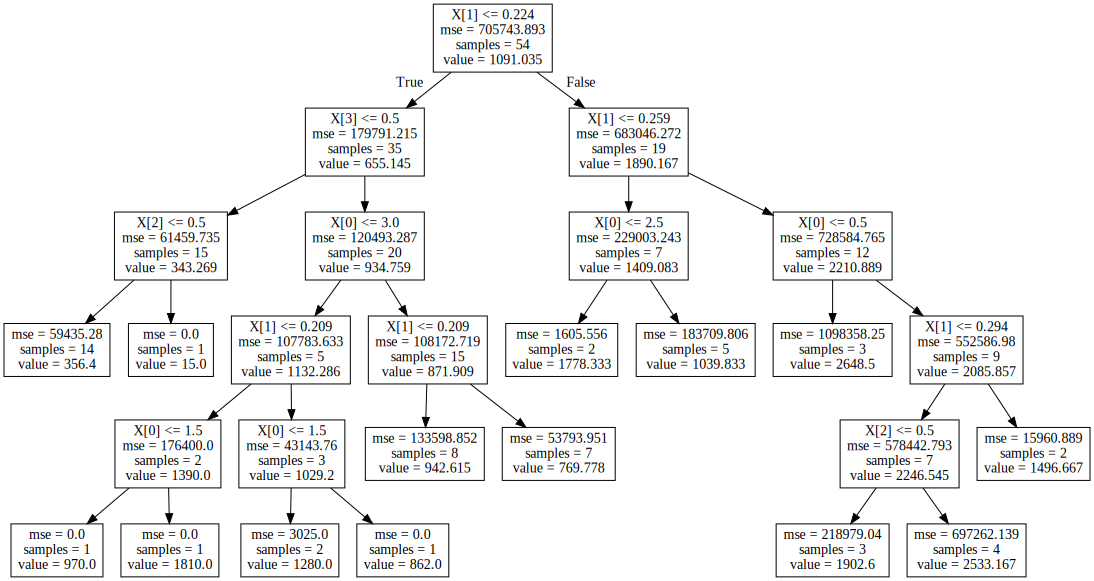

In [67]:
from sklearn.tree import export_graphviz
import graphviz

export_graphviz(decision_tree=model_rf.estimators_[30],
                out_file="tree.dot",
                impurity=True)
with open("tree.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

# 모델 저장

In [82]:
import pickle

In [83]:
filename = 'finalized_model.sav'
pickle.dump(model_dt, open(filename, 'wb'))